In [7]:
# !pip install shap
# !pip install shap scikit-learn

In [1]:
import pandas as pd
from pymongo import MongoClient
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import json_normalize

from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, roc_auc_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# import shap
# shap.initjs()

In [2]:
# Connect to MongoDB
from pymongo import MongoClient
conn = MongoClient()

In [3]:
# List datbases in Mongo
conn.list_database_names()

['admin', 'config', 'local', 'my_new_database', 'mydb', 'new_db']

In [4]:
# Choose our databse
db = conn.new_db

In [5]:
# List collections in our database
db.list_collection_names()

['new_collection']

In [6]:
# Fetch data
data = list(db.new_collection.find())

In [7]:
#transform nested JSON data into a flat table or a Pandas DataFrame
df = json_normalize(data)

In [8]:
# df = df.drop('_id', axis=1)
df = df.drop(['_id'], axis=1)

In [9]:
# change previous to categorical  
df['previous'] = df['previous'].astype('object')

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4118 entries, 0 to 4117
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             4118 non-null   int64  
 1   job             4118 non-null   object 
 2   marital         4118 non-null   object 
 3   education       4118 non-null   object 
 4   housing         4118 non-null   object 
 5   loan            4118 non-null   object 
 6   contact         4118 non-null   object 
 7   month           4118 non-null   object 
 8   day_of_week     4118 non-null   object 
 9   duration        4118 non-null   int64  
 10  campaign        4118 non-null   int64  
 11  pdays           4118 non-null   int64  
 12  previous        4118 non-null   object 
 13  poutcome        4118 non-null   object 
 14  emp_var_rate    4118 non-null   float64
 15  cons_price_idx  4118 non-null   float64
 16  cons_conf_idx   4118 non-null   float64
 17  euribor3m       4118 non-null   f

In [11]:
df.columns

Index(['age', 'job', 'marital', 'education', 'housing', 'loan', 'contact',
       'month', 'day_of_week', 'duration', 'campaign', 'pdays', 'previous',
       'poutcome', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx',
       'euribor3m', 'nr_employed', 'y'],
      dtype='object')

In [12]:
df.head()

,age,job,marital,education,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
0,0,student,single,basic.4y,no,yes,cellular,apr,wed,371,2,999,0,nonexistent,-1.8,93.075,-47.1,1.405,5099.1,1
1,0,student,single,basic.4y,yes,no,cellular,sep,wed,396,2,6,3,success,-1.1,94.199,-37.5,0.876,4963.6,1
2,0,student,single,basic.6y,yes,no,cellular,sep,thu,161,2,6,4,success,-1.1,94.199,-37.5,0.879,4963.6,1
3,0,student,single,basic.9y,no,yes,telephone,jul,mon,567,1,6,2,success,-1.7,94.215,-40.3,0.827,4991.6,1
4,0,student,single,basic.9y,yes,no,cellular,aug,tue,642,1,999,0,nonexistent,-2.9,92.201,-31.4,0.884,5076.2,1


One of the age values has not changed to a discrete one, let's get rid of it

In [13]:
df['age'].value_counts()

age
1     2288
2     1566
3      247
0       16
48       1
Name: count, dtype: int64

In [14]:
df = df[df.age != 48]

In [15]:
df['previous'].value_counts()

previous
0    3200
1     655
2     173
3      63
4      17
5       8
6       1
Name: count, dtype: int64

In [16]:
df['y'].value_counts()

y
1    2059
0    2058
Name: count, dtype: int64

--------------------------------------------

Now the data is ready we start with the ML model

In [17]:
categorical_cols = ['job', 'marital', 'education', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome', 'previous']
target_col = 'y' #term deposit

In [18]:
# One-hot encode the categorical features
df_encoded = pd.get_dummies(df, columns=categorical_cols)

In [19]:
# Separate features and target
X = df_encoded.drop(columns=[target_col])
y = df_encoded[target_col]

In [20]:
# Check for NaN values in X and y
print("NaN values in X:")
print(X.isnull().sum())

print("\nNaN values in y:")
print(y.isnull().sum())

NaN values in X:
age             0
duration        0
campaign        0
pdays           0
emp_var_rate    0
               ..
previous_2      0
previous_3      0
previous_4      0
previous_5      0
previous_6      0
Length: 63, dtype: int64

NaN values in y:
0


There are no NAN values, we go on

In [21]:
# Check if there are enough samples after cleaning
n_samples = len(X)
if n_samples == 0:
    raise ValueError("After preprocessing, there are no samples available.")

In [22]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [23]:
# Create a pipeline to scale the data and then apply logistic regression
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(random_state=42, class_weight='balanced', solver='liblinear', max_iter=1000))
])

In [24]:
# Fit the model
pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('logreg',
                 LogisticRegression(class_weight='balanced', max_iter=1000,
                                    random_state=42, solver='liblinear'))])

In [25]:
# Predict on the test set
y_pred_lr = pipeline.predict(X_test)

In [26]:
# Evaluation
print("\nClassification Report:")
print(classification_report(y_test, y_pred_lr, zero_division=0))
print('Accuracy:', accuracy_score(y_test, y_pred_lr))


Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.84      0.87       396
           1       0.86      0.91      0.88       428

    accuracy                           0.88       824
   macro avg       0.88      0.87      0.87       824
weighted avg       0.88      0.88      0.87       824

Accuracy: 0.875


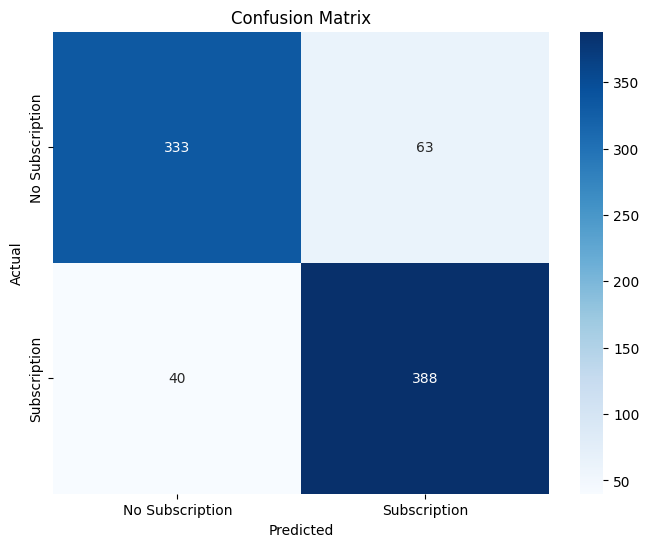

In [27]:
# Confusion Matrix
# print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred_lr))
cm = confusion_matrix(y_test, y_pred_lr)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Subscription', 'Subscription'], yticklabels=['No Subscription', 'Subscription'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [28]:
# Extract coefficients from the logistic regression model
logreg_model = pipeline.named_steps['logreg']
coefficients = logreg_model.coef_[0]
feature_names = X.columns

In [29]:
# Create a DataFrame to interpret coefficients
coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})

In [30]:
# Filter for job-related coefficients
prev_coef_df = coef_df[coef_df['Feature'].str.startswith('previous_')]

In [31]:
prev_coef_df = prev_coef_df.sort_values(by='Coefficient', ascending=False)

In [32]:
print("Logistic Regression Coefficients for Previous number of contacts:")
print(prev_coef_df)

Logistic Regression Coefficients for Previous number of contacts:
       Feature  Coefficient
60  previous_4     0.211245
61  previous_5     0.159803
56  previous_0     0.084368
58  previous_2    -0.007337
59  previous_3    -0.047604
57  previous_1    -0.122461
62  previous_6    -0.159183


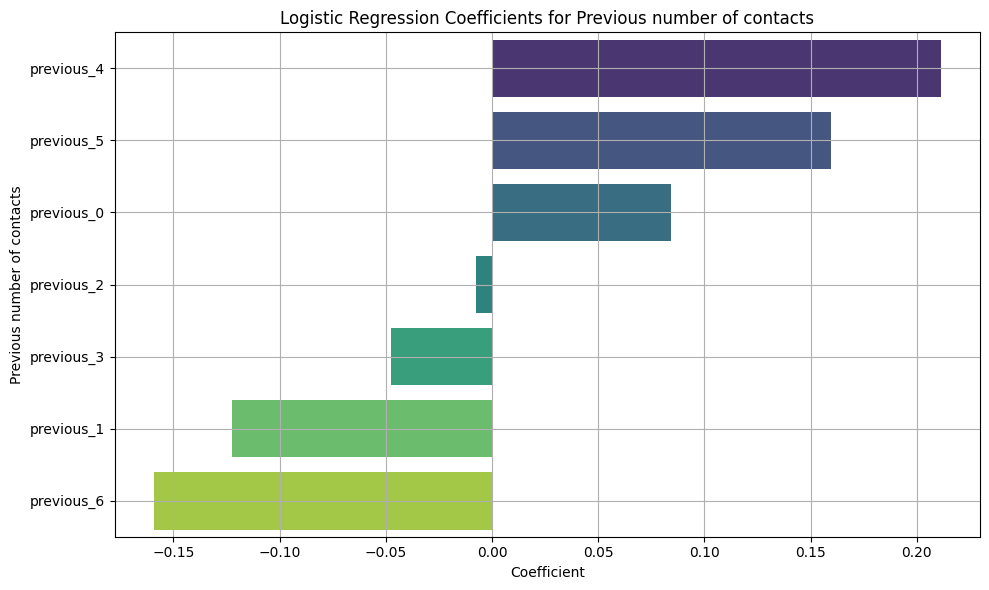

In [33]:
# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x='Coefficient', y='Feature', data=prev_coef_df, hue='Feature', dodge=False, palette='viridis', legend=False)
plt.title('Logistic Regression Coefficients for Previous number of contacts')
plt.xlabel('Coefficient')
plt.ylabel('Previous number of contacts')
plt.grid(True)
plt.tight_layout()
plt.show()

In [39]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

# Make prediction on the testing data
y_pred_RF = rf.predict(X_test)

# Classification Report
print(classification_report(y_pred_RF, y_test))
print('Accuracy:', accuracy_score(y_test, y_pred_RF))

              precision    recall  f1-score   support

           0       0.84      0.90      0.87       366
           1       0.92      0.86      0.89       458

    accuracy                           0.88       824
   macro avg       0.88      0.88      0.88       824
weighted avg       0.88      0.88      0.88       824

Accuracy: 0.8786407766990292


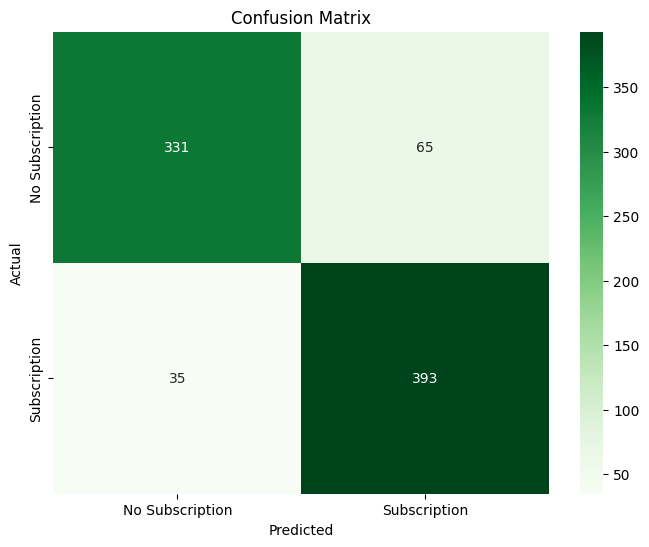

In [40]:
cm = confusion_matrix(y_test, y_pred_RF)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=['No Subscription', 'Subscription'], yticklabels=['No Subscription', 'Subscription'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

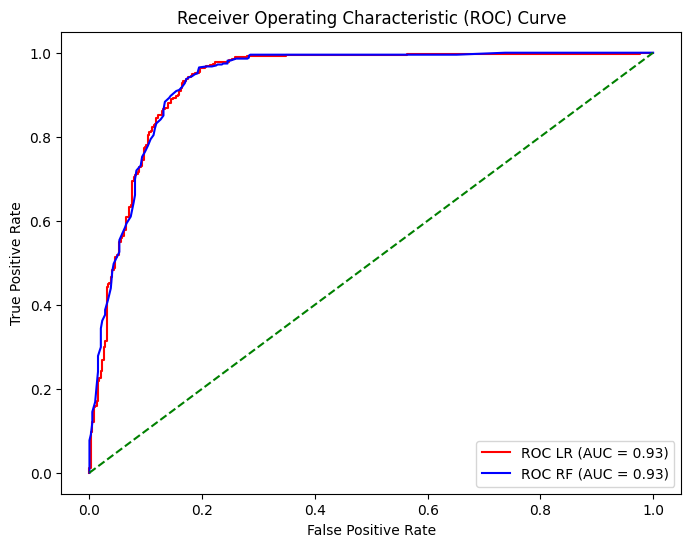

In [41]:
# ROC Curve
y_proba = pipeline.predict_proba(X_test)[:, 1]  # Get probabilities for the positive class
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc1 = roc_auc_score(y_test, y_proba)

y_proba2 = rf.predict_proba(X_test)[:, 1]  # Get probabilities for the positive class
fpr2, tpr2, thresholds2 = roc_curve(y_test, y_proba2)
roc_auc2 = roc_auc_score(y_test, y_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC LR (AUC = {roc_auc1:.2f})',color='r')
plt.plot(fpr2, tpr2, label=f'ROC RF (AUC = {roc_auc2:.2f})',color='b')
plt.plot([0, 1], [0, 1], linestyle='--', color='g')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()